In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print('Vocab size:', vocab_size)

{0: '.', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
Vocab size: 27


In [6]:
# building the dataset
block_size = 3  # context size: how many characters we consider to predict the next character

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # update context with the next character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1]) # training set
Xdev, Ydev = build_dataset(words[n1:n2]) # validation set
Xte, Yte = build_dataset(words[n2:]) # test set
            
print('Training set:', Xtr.shape, Ytr.shape)
print('Validation set:', Xdev.shape, Ydev.shape)
print('Test set:', Xte.shape, Yte.shape)

Training set: torch.Size([182580, 3]) torch.Size([182580])
Validation set: torch.Size([22767, 3]) torch.Size([22767])
Test set: torch.Size([22799, 3]) torch.Size([22799])


In [7]:
# MLP model

"""
This code defines an MLP (Multi-Layer Perceptron) model with the following components:
- n_emb: The size of the embedding layer.
- n_hidden: The size of the hidden layer.
- g: A torch.Generator object used for reproducibility.
- C: The embedding matrix with shape (vocab_size, n_emb).
- W1: The weight matrix for the first layer with shape (n_emb * block_size, n_hidden).
- b1: The bias vector for the first layer with shape (n_hidden).
- W2: The weight matrix for the second layer with shape (n_hidden, vocab_size).
- b2: The bias vector for the second layer with shape (vocab_size).
- parameters: A list containing all the model parameters.
- numel: The total number of elements in a tensor.

The code also sets the requires_grad attribute of all the parameters to True.
"""

n_emb = 10 # embedding size
n_hidden = 200 # hidden layer size

g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g) # embedding matrix
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * 0.2 # first layer initialized with small values, scaled down
b1 = torch.randn((n_hidden), generator=g) * 0.01 # bias for the first layer
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # second layer, initialized with small values, scaled down
b2 = torch.randn((vocab_size), generator=g) * 0 # bias for the second layer, initialized to zero at the beginning

parameters = [C, W1, b1, W2, b2]
print('Number of parameters:', sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True


Number of parameters: 11897


In [8]:
# Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # minibatch

    # forward pass
    emb = C[Xb] # embedding lookup
    embcat = emb.view(emb.shape[0], -1) # flatten the embedding
    hpreact = embcat @ W1 + b1 # pre-activation
    h = torch.tanh(hpreact) # non-linearity
    logits = h @ W2 + b2 # logits
    loss = F.cross_entropy(logits, Yb) # loss 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad.data

    # track statistics
    if i % 10000 == 0: # every 10000 steps
        print(f'{i:7d}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break # this is just for testing the logits for the first minibatch


      0/200000: 3.3153
  10000/200000: 2.1310
  20000/200000: 2.1120
  30000/200000: 2.3054
  40000/200000: 2.0845
  50000/200000: 1.8527
  60000/200000: 1.6734
  70000/200000: 2.2592
  80000/200000: 1.9434
  90000/200000: 1.9492
 100000/200000: 2.1447
 110000/200000: 1.6726
 120000/200000: 1.6542
 130000/200000: 2.3512
 140000/200000: 2.2032
 150000/200000: 2.0789
 160000/200000: 2.0291
 170000/200000: 2.2977
 180000/200000: 1.7612
 190000/200000: 2.1718


(array([315., 245., 204., 174., 150., 118., 127., 113., 110., 106., 125.,
         79., 116.,  82., 121., 105., 116.,  78., 108.,  97.,  92., 100.,
         92.,  80.,  84.,  84.,  86.,  96.,  80.,  90.,  74.,  85.,  94.,
        112.,  83., 106., 114., 114., 108.,  99.,  99., 143., 131., 148.,
        146., 157., 155., 222., 285., 352.]),
 array([-9.99571502e-01, -9.59591606e-01, -9.19611709e-01, -8.79631813e-01,
        -8.39651916e-01, -7.99672019e-01, -7.59692123e-01, -7.19712226e-01,
        -6.79732330e-01, -6.39752433e-01, -5.99772537e-01, -5.59792640e-01,
        -5.19812744e-01, -4.79832847e-01, -4.39852951e-01, -3.99873054e-01,
        -3.59893157e-01, -3.19913261e-01, -2.79933364e-01, -2.39953468e-01,
        -1.99973571e-01, -1.59993675e-01, -1.20013778e-01, -8.00338817e-02,
        -4.00539851e-02, -7.40885735e-05,  3.99058080e-02,  7.98857045e-02,
         1.19865601e-01,  1.59845498e-01,  1.99825394e-01,  2.39805291e-01,
         2.79785187e-01,  3.19765084e-01,  3.59744

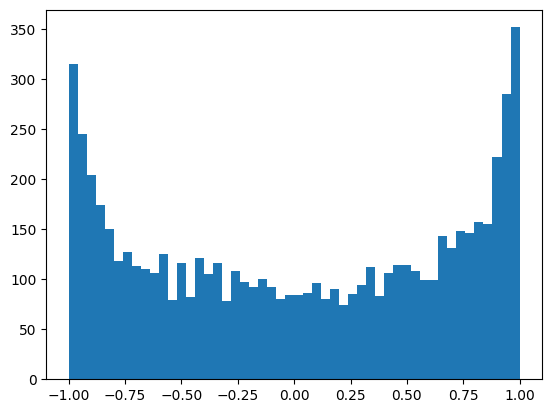

In [40]:
# next problem that the network has is with the 'h', hidden states
# purpose of tanh as we remember is to squash the values between -1 and 1, lets look at the histogram of the hidden states
# h.shape # 32 is the batch size (examples), 200 is the hidden size
# lets stretch the h to one large vector
# h.view(-1).shape # 6400 is the batch size * hidden size
plt.hist(h.view(-1).tolist(), 50)

# observe how the values are squashed between -1 and 1

# the biggest problem here is that more the values are in the flat region of the tanh, i.e. -1 and 1, the grad will be zero, 
# which means that the network will not learn anything or loss is not effected by those neurons. Ref: Autograd (1 - t**2)
# also if the value is zero, the grad is just passed through, which means tanh is not doing anything.

# how to solve this problem?
# we need to bring the values of hpreact to be closer to zero, so that tanh is not in the flat region
# to do so we multiply the hpreact with a small number, which is called scaling and same with bias (refer code)

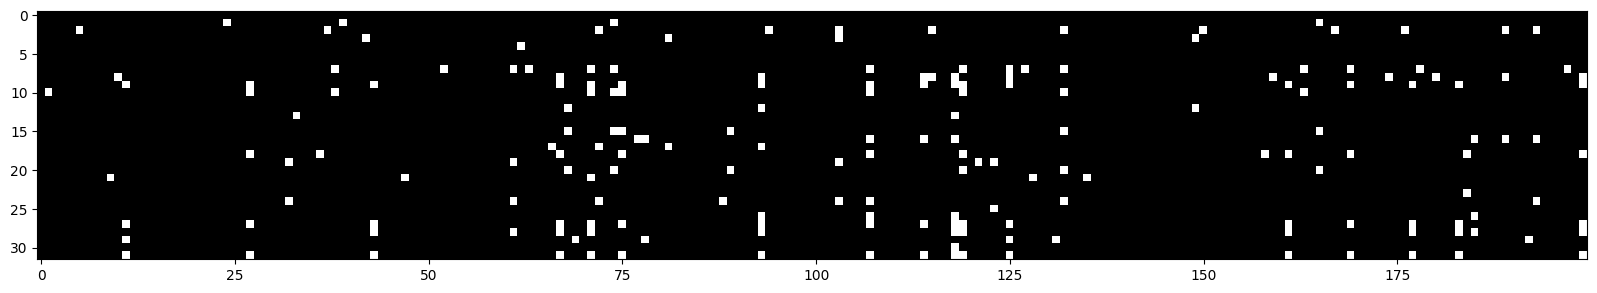

In [41]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# what we see is 32 examples and 200 neurons
# all the white ones are where the value is > 0.99, so h is in flat areas, meaning that the grad is zero for those neurons, tanh is not doing anything (gradients are destroyed)
# what is important to note is that no column is all white, because in that case the we have dead neurons.

# this happens with all activation functions, relu, sigmoid, etc.
# some neurons get knocked off for ever and are dead, they are not learning anything

# all black now :)

(array([  3.,   0.,   3.,   8.,   5.,   9.,   8.,  14.,  22.,  23.,  37.,
         59.,  74.,  70., 113., 123., 157., 198., 196., 217., 247., 290.,
        345., 381., 382., 349., 334., 354., 356., 280., 305., 253., 206.,
        170., 172., 152., 114.,  86.,  61.,  54.,  40.,  43.,  23.,  20.,
         17.,   7.,   5.,   8.,   5.,   2.]),
 array([-4.224051  , -4.05805959, -3.89206818, -3.72607677, -3.56008535,
        -3.39409394, -3.22810253, -3.06211112, -2.89611971, -2.7301283 ,
        -2.56413689, -2.39814548, -2.23215406, -2.06616265, -1.90017124,
        -1.73417983, -1.56818842, -1.40219701, -1.2362056 , -1.07021419,
        -0.90422277, -0.73823136, -0.57223995, -0.40624854, -0.24025713,
        -0.07426572,  0.09172569,  0.2577171 ,  0.42370852,  0.58969993,
         0.75569134,  0.92168275,  1.08767416,  1.25366557,  1.41965698,
         1.58564839,  1.7516398 ,  1.91763122,  2.08362263,  2.24961404,
         2.41560545,  2.58159686,  2.74758827,  2.91357968,  3.07957109,
 

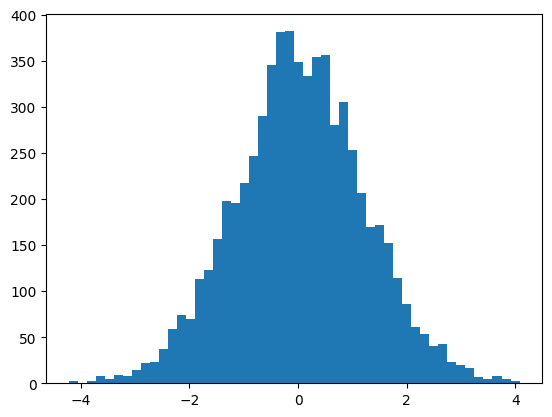

In [42]:
# lets look at the pre-activation values
plt.hist(hpreact.view(-1).tolist(), 50)

# observe how the values are between -20 and 20, we bring them to -2 and 2 by scaling

In [18]:
logits[0] # logits for the first minibatch are so random, ideally they should be equally distributed for all characters (27), this is why the loss is so high
# step 1 will be to make b2 bias 0 at the initialization time
# step 2 will be to initialize W2 with small values, scaled down. Dont set this to zero

tensor([ 0.0964,  0.1999, -0.0043, -0.0577,  0.0322,  0.1064,  0.1046, -0.1644,
         0.0295,  0.0007,  0.0558, -0.2128,  0.1318,  0.0774, -0.1508, -0.0820,
         0.0624,  0.1657, -0.1049,  0.0413, -0.0162, -0.1285, -0.1958,  0.1318,
        -0.0192,  0.1833,  0.1426], grad_fn=<SelectBackward0>)

In [49]:
# 4 dimensional example for the below
#logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) * 100 # logits are super high, the loss will go crazy
probs = F.softmax(logits, dim=0) 
loss = -probs[2].log()
logits, probs, loss

(tensor([111.9069,  16.8355, -69.7057, -47.4059]),
 tensor([1.0000e+00, 5.1400e-42, 0.0000e+00, 0.0000e+00]),
 tensor(inf))

In [44]:
# the loss 25 you see above at the initialization is really bad, what we would expect is that there is an equal probability of predicting any character, 
# so the loss should be, the network is very confidently wrong

-torch.tensor(1/27).log()

tensor(3.2958)

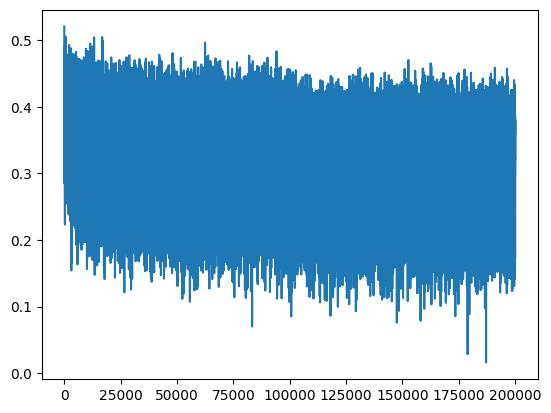

In [9]:
plt.plot(lossi)

# we squashed down the hockey stick, we spend less time or iterations to sqash down the weights rather focus more cycles on optimizing the weights

In [10]:
@torch.no_grad() # no need to track the gradients here
def split_loss(split):
    x, y = {'train': (Xtr, Ytr), 'val': (Xdev, Ydev), 'test': (Xte, Yte)} [split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.9943053722381592
val 2.0542640686035156
test 2.0619266033172607


In [47]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10) # for reproducibility

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # embedding lookup (1, block_size, n_emb)
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: # end of word
            break

    print(''.join([itos[i] for i in out]))




desie.
yrek.
ir.
lil.
nsh.
rubi.
lilder.
l.
kylin.
meri.
tziv.
j.
rij.
.
s.
nish.
dineigh.
l.
ilo.
eimn.
